Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
# using google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import glob

In [3]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')
data_dir=pathlib.Path('/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration')
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
# count the total image present in train and test folder
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
class_names1=np.array([item.name for item in data_dir.glob('Train/*')])
class_names1

array(['pigmented benign keratosis', 'dermatofibroma', 'nevus',
       'melanoma', 'vascular lesion', 'squamous cell carcinoma',
       'actinic keratosis', 'basal cell carcinoma',
       'seborrheic keratosis'], dtype='<U26')

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='training',
    image_size=(img_height,img_width),
    batch_size=batch_size)

Found 2739 files belonging to 9 classes.
Using 2192 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='validation',
    image_size=(img_height,img_width),
    batch_size=batch_size)

Found 2739 files belonging to 9 classes.
Using 547 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [11]:
image_generator=keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_data_gen=image_generator.flow_from_directory(directory=data_dir_train,batch_size=batch_size,
                                                   shuffle=True,target_size=(img_height,img_width),classes=list(class_names))

Found 2739 images belonging to 9 classes.


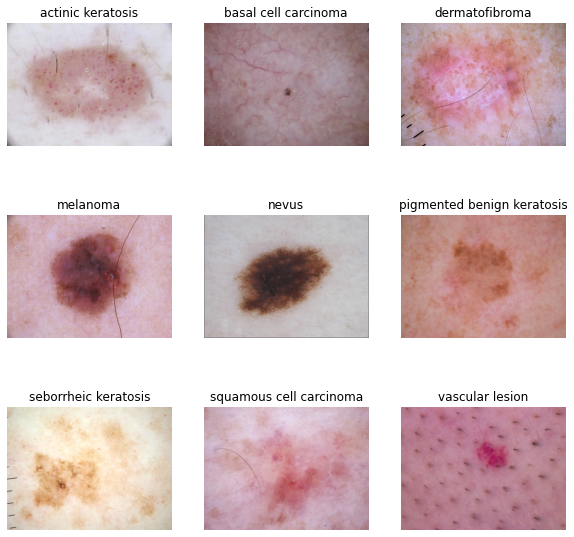

In [12]:
### your code goes here, you can use training or validation data to visualize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure(figsize=(10,10))
for index,name in enumerate(class_names):
   ax=plt.subplot(3,3,index+1)
   images=list(data_dir_train.glob(name+'/*'))
   img=mpimg.imread((str(images[0])))
   plt.imshow(img)
   plt.title(name)
   plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
### Your code goes here
num_classes = 9
# creating the model
# model = Sequential([
#   layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='softmax'),
#   layers.Dense(num_classes)
# ])
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [15]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
69/69 [==============================] - 30s 118ms/step - loss: 1.9477 - accuracy: 0.2844 - val_loss: 1.7011 - val_accuracy: 0.3675
Epoch 2/20
69/69 [==============================] - 3s 38ms/step - loss: 1.5773 - accuracy: 0.4337 - val_loss: 1.4208 - val_accuracy: 0.4973
Epoch 3/20
69/69 [==============================] - 3s 38ms/step - loss: 1.3275 - accuracy: 0.5189 - val_loss: 1.5174 - val_accuracy: 0.4625
Epoch 4/20
69/69 [==============================] - 3s 38ms/step - loss: 1.2361 - accuracy: 0.5698 - val_loss: 1.3528 - val_accuracy: 0.5119
Epoch 5/20
69/69 [==============================] - 3s 38ms/step - loss: 1.1526 - accuracy: 0.5861 - val_loss: 1.4338 - val_accuracy: 0.4936
Epoch 6/20
69/69 [==============================] - 3s 38ms/step - loss: 1.0089 - accuracy: 0.6317 - val_loss: 1.4338 - val_accuracy: 0.5265
Epoch 7/20
69/69 [==============================] - 3s 38ms/step - loss: 0.8916 - accuracy: 0.6785 - val_loss: 1.2289 - val_accuracy: 0.6106
Epoch 8/20


### Visualizing training results

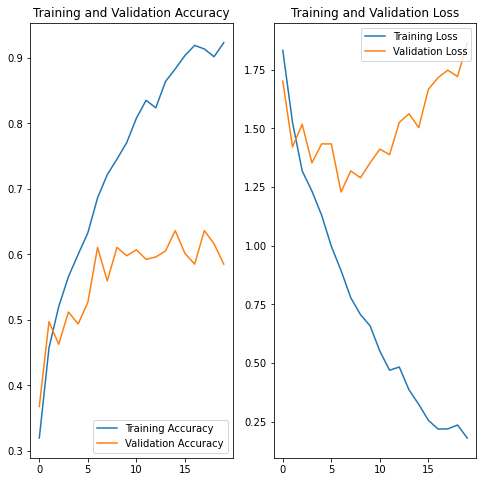

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

By Observing the above grapgh, i see train and validation accuracy away from each other, which is a clear sign of overfitting

In [19]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

#By Observing the above grapgh, i see train and validation accuracy away from each other, which is a clear sign of overfitting

In [20]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
# Data Augmentation
data_augmentation=keras.Sequential([
                                    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
                                    layers.experimental.preprocessing.RandomRotation(0.1),
                                    layers.experimental.preprocessing.RandomZoom(0.1)])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


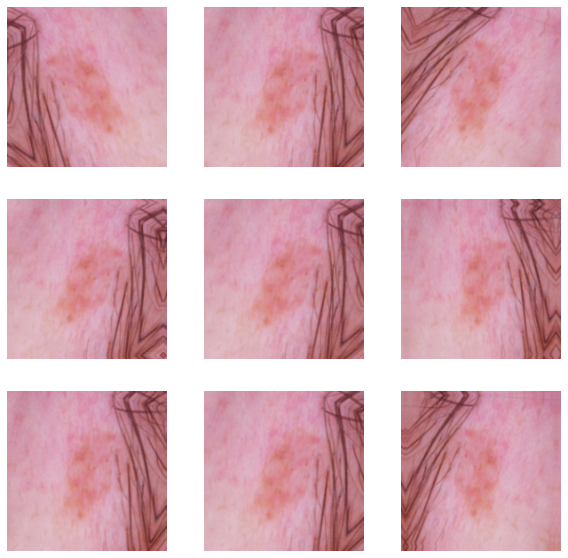

In [21]:
# visualising the augmented image
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(7):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [22]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Dropout(0.25),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

### Compiling the model

In [23]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 64)      1792      
_________________________________________________________________
dropout (Dropout)            (None, 180, 180, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        18464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)       

### Training the model

In [25]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
69/69 [==============================] - 9s 108ms/step - loss: 1.9998 - accuracy: 0.2758 - val_loss: 1.8577 - val_accuracy: 0.3236
Epoch 2/20
69/69 [==============================] - 7s 100ms/step - loss: 1.8158 - accuracy: 0.3294 - val_loss: 1.7553 - val_accuracy: 0.3565
Epoch 3/20
69/69 [==============================] - 7s 102ms/step - loss: 1.7252 - accuracy: 0.3578 - val_loss: 1.6108 - val_accuracy: 0.3766
Epoch 4/20
69/69 [==============================] - 7s 100ms/step - loss: 1.6832 - accuracy: 0.3813 - val_loss: 1.5775 - val_accuracy: 0.4406
Epoch 5/20
69/69 [==============================] - 7s 100ms/step - loss: 1.4572 - accuracy: 0.4855 - val_loss: 1.5129 - val_accuracy: 0.4168
Epoch 6/20
69/69 [==============================] - 7s 100ms/step - loss: 1.3906 - accuracy: 0.4849 - val_loss: 1.4144 - val_accuracy: 0.4991
Epoch 7/20
69/69 [==============================] - 7s 100ms/step - loss: 1.3934 - accuracy: 0.4986 - val_loss: 1.3206 - val_accuracy: 0.5119
Epoch 

### Visualizing the results

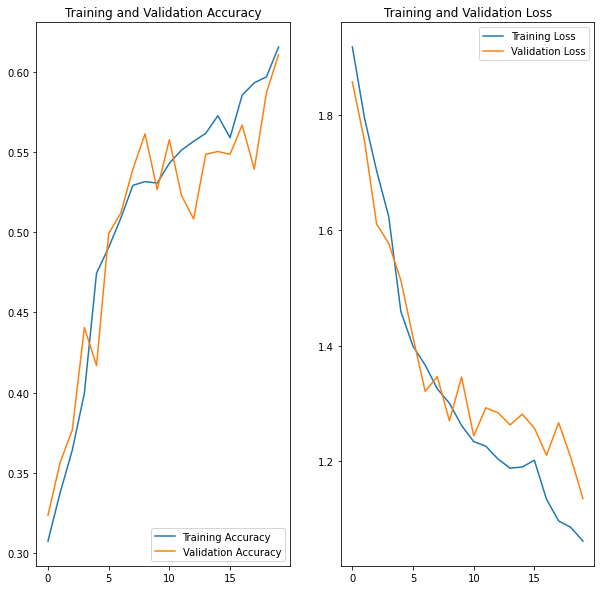

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [27]:
from sklearn.datasets import load_files 
from keras.utils import np_utils
def load_data_raw (path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 9)
    
    return files, targets

train_filenames, train_targets = load_data_raw(data_dir_train)

<BarContainer object of 9 artists>

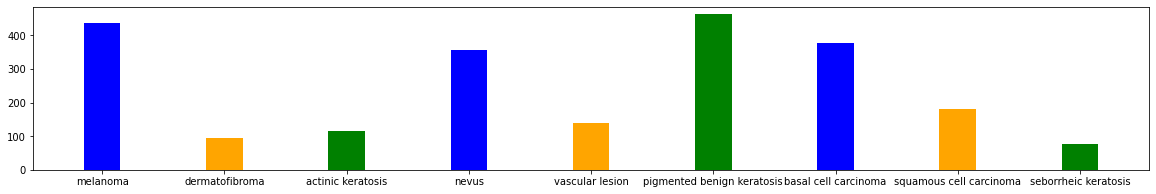

In [28]:
from collections import Counter
filenames_trimmed = [filename.split('/')[-2] for filename in train_filenames]
classes_count = Counter(filenames_trimmed)

# Plot the classes
plt.figure(figsize=(20, 3))
plt.bar(classes_count.keys(), classes_count.values(), color=['blue', 'orange', 'green'],width=0.3)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [29]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [30]:
# creating image
path_to_training_dataset="/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE320994D10>:   0%|          | 1/500 [00:00<00:54,  9.18 Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE31D09C650>: 100%|██████████| 500/500 [00:21<00:00, 23.06 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE31D10B8D0>: 100%|██████████| 500/500 [00:21<00:00, 23.78 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE31D0A6150>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE31D075E90>: 100%|██████████| 500/500 [00:21<00:00, 23.07 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FE31D108E10>: 100%|██████████| 500/500 [01:32<00:00,  5.43 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FE31D0D3CD0>: 100%|██████████| 500/500 [01:32<00:00,  5.38 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE31D049C90>: 100%|██████████| 500/500 [00:22<00:00, 22.50 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FE320988A90>: 100%|██████████| 500/500 [00:47<00:00, 10.62 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE382101510>: 100%|██████████| 500/500 [00:21<00:00, 23.65 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE31CFF4590>:   0%|          | 2/500 [00:00<00:59,  8.32 Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE382101D10>: 100%|██████████| 500/500 [00:21<00:00, 23.22 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [31]:
# count created image total
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [32]:
import glob
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(path_list_new)
print(path_list_new)

['/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024943.jpg_e41480a1-9378-40ee-b1d9-098c76b05ac9.jpg', '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026280.jpg_e91057cf-2453-4f02-aa78-9a9d19f0fe8b.jpg', '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028376.jpg_5ce7c18f-9f88-41b8-b59d-8c2b8a98ccfc.jpg', '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026443.jpg_ed50cecb-0e1e-4c01-8260-53b3e5a16c08.jpg', '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign ke

In [33]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
print(len(lesion_list_new))
print(lesion_list_new)

4500
['pigmented benign keratosis', 'pigmented benign keratosis', 'pigmented benign keratosis', 'pigmented benign keratosis', 'pigmented benign keratosis', 'pigmented benign keratosis', 'pigmented benign keratosis', 'pigmented benign keratosis', 'pigmented benign keratosis', 'pigmented benign keratosis', 'pigmented benign keratosis', 'pigmented benign keratosis', 'pigmented benign keratosis', 'pigmented benign keratosis', 'pigmented benign keratosis', 'pigmented benign keratosis', 'pigmented benign keratosis', 'pigmented benign keratosis', 'pigmented benign keratosis', 'pigmented benign keratosis', 'pigmented benign keratosis', 'pigmented benign keratosis', 'pigmented benign keratosis', 'pigmented benign keratosis', 'pigmented benign keratosis', 'pigmented benign keratosis', 'pigmented benign keratosis', 'pigmented benign keratosis', 'pigmented benign keratosis', 'pigmented benign keratosis', 'pigmented benign keratosis', 'pigmented benign keratosis', 'pigmented benign keratosis', 'pig

In [34]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [35]:
path_list=[x for x in glob.glob(os.path.join(data_dir_train,'*','*.jpg'))]
len(path_list)

2239

In [36]:
lesion_list= [i.split('/')[-2] for i in path_list]
len(lesion_list)

2239

In [37]:
dataframe_dict = dict(zip(path_list, lesion_list))

In [38]:
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

In [39]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])


In [40]:
#merging all the image
new_df = original_df.append(df2)

In [41]:
# total number of image present available in all folder
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [42]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [43]:
data_dir_train="/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds =tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='training',
    image_size=(img_height,img_width),
    batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [44]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='validation',
    image_size=(img_height,img_width),
    batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [45]:
## your code goes here
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Dropout(0.25),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [46]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [47]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 64)      1792      
_________________________________________________________________
dropout_2 (Dropout)          (None, 180, 180, 64)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        18464     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)       

#### **Todo:**  Train your model

In [48]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 64s 367ms/step - loss: 2.1156 - accuracy: 0.1740 - val_loss: 1.7278 - val_accuracy: 0.3593
Epoch 2/50
169/169 [==============================] - 63s 363ms/step - loss: 1.6265 - accuracy: 0.3964 - val_loss: 1.4275 - val_accuracy: 0.4633
Epoch 3/50
169/169 [==============================] - 63s 362ms/step - loss: 1.4225 - accuracy: 0.4568 - val_loss: 1.4725 - val_accuracy: 0.4298
Epoch 4/50
169/169 [==============================] - 63s 364ms/step - loss: 1.3896 - accuracy: 0.4733 - val_loss: 1.2780 - val_accuracy: 0.5041
Epoch 5/50
169/169 [==============================] - 62s 359ms/step - loss: 1.2859 - accuracy: 0.5054 - val_loss: 1.3021 - val_accuracy: 0.4766
Epoch 6/50
169/169 [==============================] - 61s 355ms/step - loss: 1.2347 - accuracy: 0.5322 - val_loss: 1.2536 - val_accuracy: 0.5219
Epoch 7/50
169/169 [==============================] - 62s 356ms/step - loss: 1.2228 - accuracy: 0.5248 - val_loss: 1.1418 - val_ac

#### **Todo:**  Visualize the model results

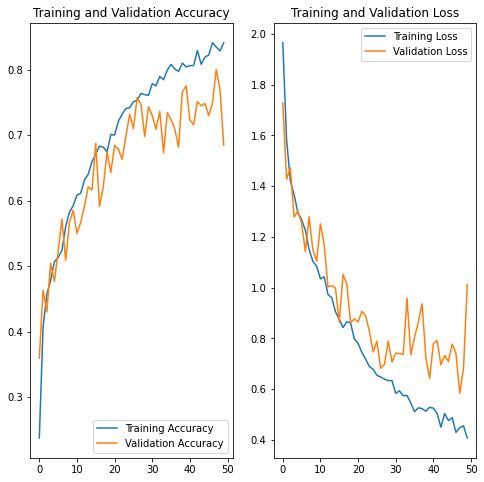

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



After adding augmrententation image,The train and validation have increased and balanced, and by observing the graph i can see, it's imporved a lot from base model, overfitting is reduced drastically 